Extract aggregated data for biological groups for MPRI spill scenarios

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = {'TP': [1, 2, 3, 4, 5, 6, 7, 8, 9, 60, 33, 66],'AP': [60, 62, 63], 'EB': [75, 80], 'JF': [1, 2]}

### Define scenario and control files

In [3]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])

In [4]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

Scenario_4a_1_2019-07-04 low Fraser flow spring tide summer
Scenario_4a_2_2019-07-10 low Fraser flow neap tide summer
Scenario_4a_3_2020-07-22 high Fraser flow spring tide summer
Scenario_4a_4_2020-07-12 high Fraser flow neap tide summer
Scenario_5b_1_2019-01-20 low Fraser flow spring tide winter
Scenario_5b_2_2019-01-14 low Fraser flow neap tide winter
Scenario_5b_3_2020-01-24 high Fraser flow spring tide winter
Scenario_5b_4_2020-01-16 high Fraser flow neap tide winter
Scenario_6a_1_2019-07-16 low Fraser flow spring tide summer
Scenario_6a_2_2019-07-25 low Fraser flow neap tide summer
Scenario_6a_3_2020-07-21 high Fraser flow spring tide summer
Scenario_6a_4_2020-07-13 high Fraser flow neap tide summer
Scenario_7a_1_2019-01-21 low Fraser flow spring tide winter
Scenario_7a_2_2019-01-26 low Fraser flow neap tide winter
Scenario_7a_3_2020-01-11 high Fraser flow spring tide winter
Scenario_7a_4_2020-01-03 high Fraser flow neap tide winter


In [5]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [6]:
# start and end time of data display, after burn-in
start = 100
end = time.size-1

In [7]:
days2019winter = [110, 130, 151, 191]
days2020winter = [118, 134, 154, 195]
days2019summer = [116, 132, 152, 193]
days2020summer = [120, 136, 156, 197]

In [8]:
plankton = {
    'microzooplankton':'MicroZoo', 'carnivorous zooplankton':'Carniv_Zoo', 'gelatinous zooplantkon':'Gelat_Zoo', 
    'mesozooplankton':'Zoo', 'diatoms':'Diatom', 'picophytoplankton':'PicoPhytopl', 'pelagic bacteria':'Pelag_Bact',
    'squid':'Squid',
}

pelagic_fish = {
    'small pelagic':'Small_pelagic_fish', 
    'hake':'Hake','lingcod':'Lingcod', 'pollock':'Pollock', 
    'rockfish':'Rockfish', 'pacific herring':'Pacific_herring',
}

demersal_fish = {
    'benthopelagic':'Benthopelagic', 'small demersal':'Small_Demersal_fish', 
    'large demersal':'Large_Demersal_fish', 'small flatfish':'Small_Flatfish', 'large flatfish':'Large_Flatfish',
    'sandlance':'Sandlance',
}

whales = {
    'humpbacks':'Humpback_whales',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}

porpoises = {
    'porpoises':'Harbor_porpoise', 
}

In [9]:
def aggregate_boxplot_data_pelagic(bio_group, bio_group_name, location=groups.salish_sea):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        if '2019-01'in year:
            end_days = days2019winter
        elif '2020-01' in year:
            end_days = days2020winter
        elif '2019-07' in year:
            end_days = days2019summer
        elif '2020-07' in year:
            end_days = days2020summer

        results = []
        for day in end_days: 
            p_oiled = 0
            p_control = 0
            for species in bio_group: 
                p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
            
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            results.append(p_ratio)
            
        for label, value in zip(data_labels, results):
            all_results.append({
            'bio_group': bio_group_name,
            'time_label': label,
            'scenario': scenario_name,
            'percent_change': value
        })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/aggregated-data-"+bio_group_name+".csv")

In [10]:
def aggregate_boxplot_data_vertebrates(bio_group, bio_group_name, location=groups.salish_sea):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        if '2019-01'in year:
            end_days = days2019winter
        elif '2020-01' in year:
            end_days = days2020winter
        elif '2019-07' in year:
            end_days = days2019summer
        elif '2020-07' in year:
            end_days = days2020summer

        results = []
        for day in end_days: 
            p_oiled = 0
            p_control = 0
            
            for species in bio_group:

                o_weightatage = 0
                c_weightatage = 0
                
                numCohorts = groups.cohorts[bio_group[species]]
                for cohort in range (1, numCohorts+1):
                    new_species = bio_group[species] + str(cohort)
                
                    o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                    o_weightatage = o_weightatage + o_weightatage_tbl

                    c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                    c_weightatage = c_weightatage + c_weightatage_tbl
            
                p_oiled = p_oiled + o_weightatage
                p_control = p_control + c_weightatage

            p_oiled = p_oiled.sum(axis=(1,2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            results.append(p_ratio)
            
        for label, value in zip(data_labels, results):
            all_results.append({
            'bio_group': bio_group_name,
            'time_label': label,
            'scenario': scenario_name,
            'percent_change': value
        })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/aggregated-data-"+bio_group_name+".csv")

In [11]:
def aggregate_boxplot_data_benthic(bio_group, bio_group_name, location=groups.salish_sea):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        if '2019-01'in year:
            end_days = days2019winter
        elif '2020-01' in year:
            end_days = days2020winter
        elif '2019-07' in year:
            end_days = days2019summer
        elif '2020-07' in year:
            end_days = days2020summer

        results = []
        for day in end_days: 
            p_oiled = 0
            p_control = 0
            for species in bio_group: 
                p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location], np.nan)
            
            p_oiled = p_oiled.sum(axis=1).mean()
            p_control = p_control.sum(axis=1).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            results.append(p_ratio)
            
        for label, value in zip(data_labels, results):
            all_results.append({
            'bio_group': bio_group_name,
            'time_label': label,
            'scenario': scenario_name,
            'percent_change': value
        })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/aggregated-data-"+bio_group_name+".csv")

In [12]:
aggregate_boxplot_data_pelagic(plankton, 'plankton')

In [13]:
aggregate_boxplot_data_benthic(groups.benthic_invertebrates, 'benthic_invertebrates')

In [14]:
aggregate_boxplot_data_vertebrates(groups.salmon, 'salmon')

In [15]:
aggregate_boxplot_data_vertebrates(demersal_fish, 'demersal_fish')

In [16]:
aggregate_boxplot_data_vertebrates(pelagic_fish, 'pelagic_fish')

In [17]:
aggregate_boxplot_data_vertebrates(whales, 'whales')

In [18]:
aggregate_boxplot_data_vertebrates(porpoises, 'porpoises')

In [19]:
aggregate_boxplot_data_vertebrates(groups.sharks, 'sharks')

In [20]:
results_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/')
results_paths = sorted([p for p in results_root.glob('aggregated-data-*.csv')])
aggregated_data = []
for file in results_paths:
    df1 = pd.read_csv(file)
    aggregated_data.append(df1[['bio_group', 'time_label','scenario', 'percent_change']])

aggregated_data_df = pd.concat(aggregated_data, ignore_index=True)
aggregated_data_df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/aggregated_data.csv")

In [21]:
df = pd.read_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/aggregated_data.csv")

In [22]:
code_names = {'EB','AP','JF','TP'}

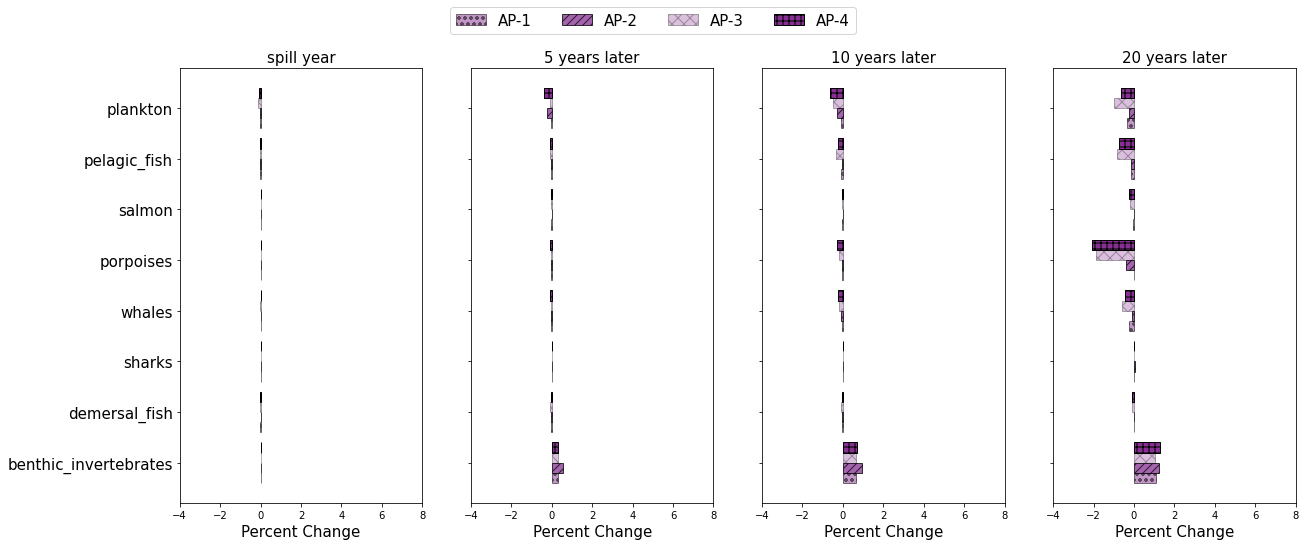

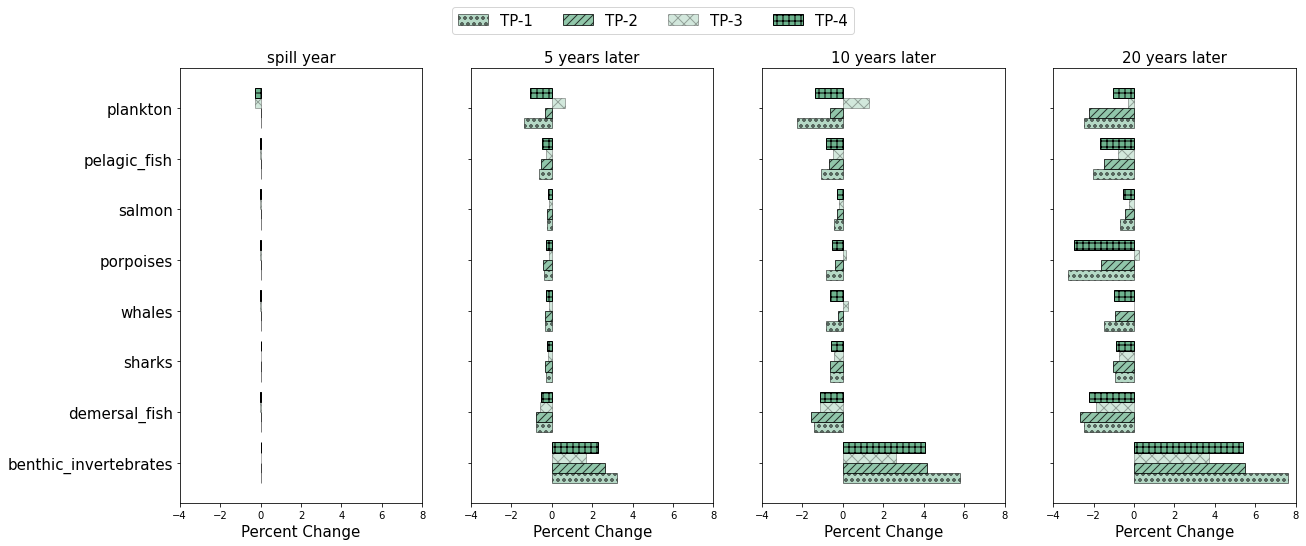

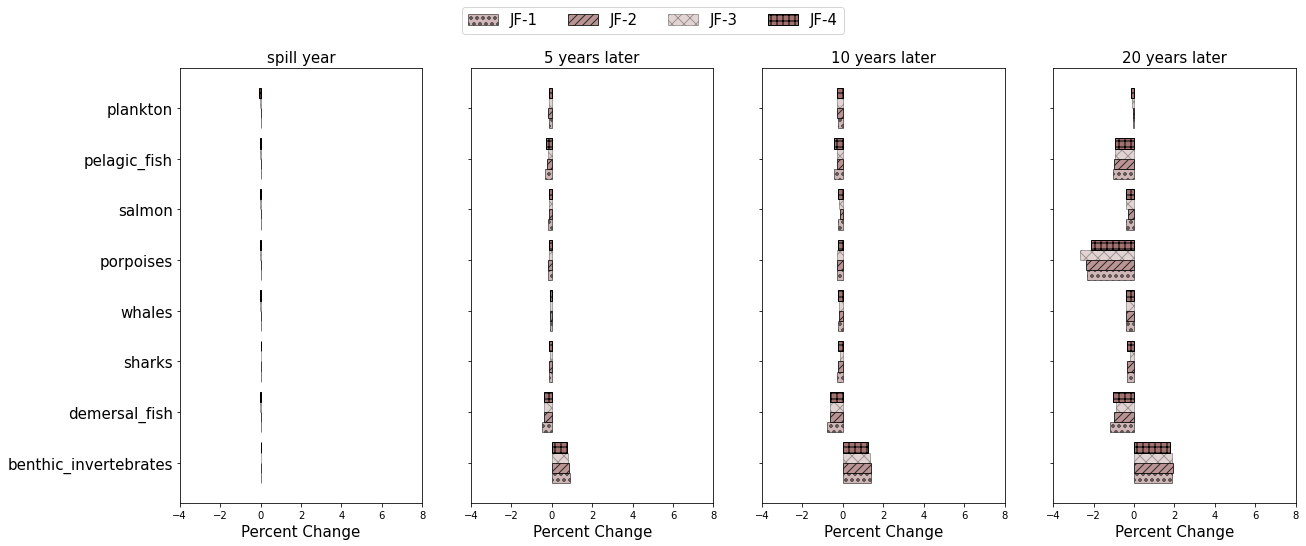

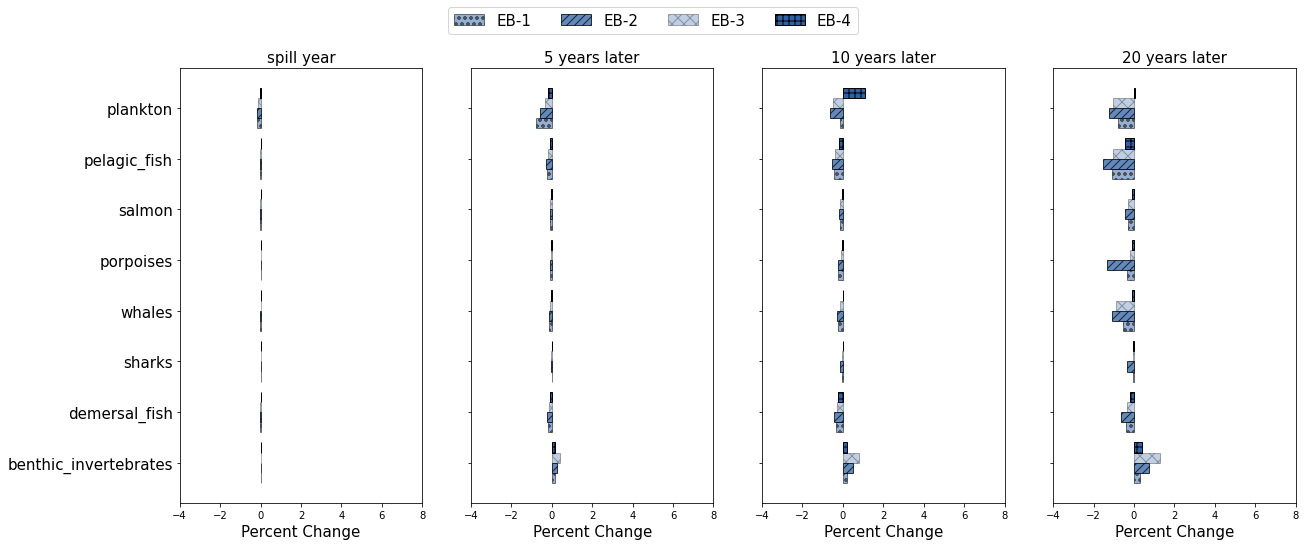

In [28]:
time_labels = df['time_label'].unique()
scenarios = df['scenario'].unique()
bio_groups = ['benthic_invertebrates','demersal_fish', 'sharks', 'whales','porpoises', 'salmon', 'pelagic_fish', 'plankton'] #df['bio_group'].unique()
hatches = ['oo', '///', 'xx', '++']
alphas = [0.5, 0.75, 0.3, 1]
colors = plt.cm.tab10.colors
x_lim = [-4,8]

for code_name in code_names:
    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 7
    elif n_rows >10:
        n_rows = 15
    else:
            n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    if code_name == 'AP':
        hex_colour = '#863092'
    elif code_name == 'TP':
        hex_colour = '#6DB48E'
    elif code_name == 'EB':
        hex_colour = '#2F61A4'
    elif code_name == 'JF':
        hex_colour = '#A27170'
    
    these_scenarios = [code_name+'-1',code_name+'-2',code_name+'-3',code_name+'-4']

    bar_width = 0.8 / len(these_scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(these_scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(these_scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=alphas[j], edgecolor='black', hatch=hatches[j])
    
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=15)

    fig.legend(these_scenarios, loc='upper center', ncol=len(these_scenarios), fontsize=15) 
    plt.show()